In [ ]:
import numpy as np
# fix old numpy code in LVISEval (np.float is deprecated)
if not hasattr(np, "float"):
    np.float = float
import torch
import torchvision
import lvis
import requests
import sys
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from constants import *
from typing import List, Tuple, Literal

## Data

In [39]:
from torch.utils.data import Dataset
from torchvision.io import decode_image
from torchvision import tv_tensors
from torchvision.ops import box_convert
from PIL import Image
from io import BytesIO

# with help of https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html


class LVISDataset(Dataset):
    def __init__(self, img_dirs: List[str], lvis_gt: lvis.LVIS|FilteredLVIS, transforms=None,
                 cat_ids=None) -> None:
        self.img_dirs = img_dirs
        self.lvis_gt = lvis_gt
        self.transforms = transforms
        self._create_index(cat_ids) 

    def _create_index(self, cat_ids):
        self.img_ids = self.lvis_gt.get_img_ids() if cat_ids is None else self._get_img_ids(cat_ids)
        self.cat_ids = self.lvis_gt.get_cat_ids() if cat_ids is None else cat_ids
        self.cat_id_to_label = {cat_id: i+1 for i, cat_id in enumerate(self.cat_ids)}
        self.label_to_cat_id = {i+1: cat_id for i, cat_id in enumerate(self.cat_ids)}
        if  all(isinstance(dir, str) for dir in self.img_dirs) and all(os.path.isdir(dir) for dir in self.img_dirs):
            self._get_image = self._get_image_from_file
            print("will load images from files")
        else:
            self._get_image = self._get_image_from_url
            print("will load images from urls")

    def _get_img_ids(self, cat_ids):
        return list({
            iid for cat_id in cat_ids
            for iid in self.lvis_gt.cat_img_map[cat_id]
        })
    
    def _get_image_from_file(self, id):
        image_paths = [os.path.join(images_dir, f'{str(id).zfill(12)}.jpg') for images_dir in self.img_dirs]
        for image_path in image_paths:
            if os.path.isfile(image_path):
                return decode_image(image_path)
        print(f"image not found: {image_paths}")
        sys.exit(1)

    def _get_image_from_url(self, id):
        url = self.lvis_gt.imgs[id]['coco_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img
    
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx: int):
        ### get image
        img_id = self.img_ids[idx]
        img = self._get_image(img_id)
        img = tv_tensors.Image(img)
        _, h, w = img.shape

        ### get annotationss
        annot_ids = self.lvis_gt.get_ann_ids(img_ids=[img_id])
        annots = self.lvis_gt.load_anns(annot_ids)
        annots = [annot for annot in annots if annot['category_id'] in self.cat_ids]
        # labels
        labels = torch.tensor([self.cat_id_to_label[annot['category_id']] for annot in annots])
        # area
        areas = torch.tensor([annot['area'] for annot in annots])
        # boxes
        boxes = torch.tensor([annot['bbox'] for annot in annots], dtype=torch.float32)
        boxes_xyxy = box_convert(boxes, in_fmt='xywh', out_fmt='xyxy')
        boxe_tv = tv_tensors.BoundingBoxes(boxes_xyxy, format= 'XYXY', canvas_size=(h,w)) # type: ignore
        # masks
        masks = [torch.from_numpy(self.lvis_gt.ann_to_mask(ann)) for ann in annots] # shape: (N, H, W)
        mask_tv = tv_tensors.Mask(torch.stack(masks))

        target = {}
        target['image_id'] = img_id
        target['labels'] = labels
        target['area'] = areas
        target['boxes'] = boxe_tv
        target['masks'] = mask_tv

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

## Model

In [15]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


# with help of https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html


# TODO check (sample code)
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features # type: ignore
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # type: ignore
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model


## Utils

#### Data

In [16]:
from torchvision.transforms import v2 as T
from typing import Tuple


def get_transform(img_size: Tuple[int, int] | None = None):
    transforms = []
    if img_size is not None:
        transforms.append(T.Resize(img_size))
    transforms.append(T.ToDtype(torch.float32, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


def custom_collate_fn(batch):
    """
    Custom collate function to prevent stacking of images with different shapes
    """
    return tuple(zip(*batch))


def get_filtered_cat_ids(cats, names):
    """
    Get a list of ids of given list of categories
    """
    cat_ids = []
    cat_names = []
    for id, cat in cats.items():
        if cat['name'] in names:
            cat_ids.append(id)
            cat_names.append(cat['name'])
    print(f'category found for {[name for name in names if name in cat_names]}')
    print(f'category NOT found for {[name for name in names if name not in cat_names]}\n')
    return cat_ids

#### Train

In [ ]:
from lvis import LVISResults, LVISEval
import pycocotools.mask as maskUtils
import math


def train_one_epoch(model, optimizer, data_loader, epoch, device, print_freq:None|int =10):
    model.train()
    total_batches = len(data_loader)
    lr_scheduler = None
    if epoch==0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    for i, (images, targets) in tqdm(enumerate(data_loader), total=total_batches, desc="TRAIN EPOCH (/batches)"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if print_freq is not None and i % print_freq == 0:
            tqdm.write(f"[batch {i+1}/{total_batches}] loss: {loss_value}")
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training \nLoss dict:\n{loss_dict}")
            sys.exit(1)
        if lr_scheduler is not None:
            lr_scheduler.step()
    return loss_value


@torch.no_grad()
def compute_val_loss(model, data_loader, device):
    model.train()
    total_batches = len(data_loader)
    total_loss = 0
    for images, targets in tqdm(data_loader, total=total_batches, desc="VALIDATION (/batches)"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        total_loss += sum(loss.item() for loss in loss_dict.values())
    return total_loss / total_batches


# TODO masks do not seem to be in the right format
@torch.inference_mode()
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    for images, targets in tqdm(data_loader, total=len(data_loader), desc="BATCHES"):
        images = list(image.to(device) for image in images)
        outputs = model(images)
        for o, t in zip(outputs, targets):
            image_id = t["image_id"]
            boxes = o["boxes"].cpu().numpy()
            scores = o["scores"].cpu().numpy()
            labels = o["labels"].cpu().numpy()
            masks = o["masks"].cpu().numpy()[:, 0, :, :]
            for box, score, label, mask in zip(boxes, scores, labels, masks):
                mask_bin = (mask > 0.5).astype(np.uint8)
                rle = maskUtils.encode(np.asfortranarray(mask_bin))
                rle['counts'] = rle['counts'].decode('utf-8')
                x1, y1, x2, y2 = box
                predictions.append({
                    "image_id": image_id,
                    "category_id": data_loader.dataset.dataset.label_to_cat_id[int(label)], # dict inside dataset in subset in loader
                    "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                    "segmentation":rle,
                    "score": float(score)
                })
    return predictions


@torch.inference_mode()
def evaluate(model, data_loader, lvis_gt, cat_ids, device, iou_type:Literal["bbox","segm"]="segm"):
    predictions = get_predictions(model, data_loader, device)
    if len(predictions) == 0:
        print("No detections — skipping LVIS evaluation.")
    else:
        lvis_dt = LVISResults(lvis_gt, predictions)
        lvis_eval = LVISEval(lvis_gt, lvis_dt, iou_type)
        lvis_eval.params.cat_ids = cat_ids
        lvis_eval.run()
        lvis_eval.print_results()


def train(model, optimizer, lr_scheduler, train_loader, val_loader, lvis_gt_val, cat_ids, epochs, patience, device, print_freq:None|int =10):
    train_losses = []
    val_losses = []
    best_model_epoch = 0
    best_loss = float('inf')
    epochs_no_improvement = 0

    for epoch in tqdm(range(epochs), desc= 'TRAINING LOOP (/epochs)'):
        loss_train = train_one_epoch(model, optimizer, train_loader, epoch, device, print_freq=print_freq)
        train_losses.append(loss_train)

        evaluate(model, val_loader, lvis_gt_val, cat_ids, device)
        loss_val = compute_val_loss(model, val_loader, device)
        val_losses.append(loss_val)

        tqdm.write(f"[epoch {epoch}/{epochs}]: train loss = {loss_train} | val loss = {loss_val}")
        if loss_val < best_loss:
            best_loss = loss_val
            best_model_epoch = epoch
            epochs_no_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improvement += 1
            tqdm.write(f"NO improvement [{epochs_no_improvement}/{patience}]")
            if epochs_no_improvement > patience:
                print("Patience reached, stopping training")
                break
        lr_scheduler.step()
    return train_losses, val_losses, best_model_epoch

#### Plot

In [18]:
def makeImagesPlotReady(msk, shape):
    return (np.rot90(np.rot90(np.rot90((msk.reshape(shape[0], shape[1], shape[2])).T))))

def show_image(image):
    _image = image if image.ndim == 3 else image[0]
    _, w, h = _image.size()
    plt.figure(figsize=(5 * (w / h), 5 * (h / w)))
    _image = makeImagesPlotReady(_image, _image.size())
    plt.imshow(_image)
    plt.axis('off')
    plt.show()

def show_image_list(images):
    n_images = len(images)
    images = [makeImagesPlotReady(img, img.size()) for img in images]
    _, axs = plt.subplots(1, n_images, figsize=(3 * n_images, 3))
    axs = axs.flatten()
    for i in range(n_images):
        axs[i].imshow(images[i])
        axs[i].axis('off')
    plt.show()

def plot_losses(train_losses, val_losses, early_stop = None, filepath=None):
    _, ax = plt.subplots(figsize=((12, 6)))
    epochs = np.arange(1,len(train_losses)+1,1)
    ax.plot(epochs, train_losses, 'r', label='Training Loss')
    ax.plot(epochs, val_losses, 'g', label='Validation Loss')
    if early_stop is not None:
        plt.scatter(epochs[early_stop], val_losses[early_stop], marker='x', c='g', label='Saved Model Epoch')
    ax.set_title('Loss Plots')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc="upper right")
    plt.show()
    if filepath is not None: 
        plt.savefig(filepath)

## Pipeline

#### Arguments

In [19]:
# Data args
MAX_IMAGES = 20 # -1:all & max_image_val = max_image_train // 5 (80/20 split)
CATEGORIES = ['cat', 'dog']  #, 'cow', 'pigeon', 'giraffe', 'bear']

#We absolutely need a resize or use a btach of one
IMG_SIZE = None #(256, 256)  # if None: no resize

# Learning args
BATCH_SIZE = 3
EPOCHS = 3
PATIENCE = 5
DEVICE = 'cpu'
NUM_WORKERS = 0 # int (0: main process)
PRINT_FREQ = 1 # int|None (None: no print inside epoch)

#### Data Preparation

In [9]:
from lvis import LVIS

lvis_gt_train = LVIS(TRAIN_ANNOT_PATH) #, CATEGORIES)
lvis_gt_val = LVIS(VAL_ANNOT_PATH) #, CATEGORIES)

In [ ]:
from torch.utils.data import DataLoader, Subset

cat_ids = get_filtered_cat_ids(lvis_gt_train.cats, CATEGORIES)
num_classes = len(cat_ids) + 1  # +1 for background

dataset_train = LVISDataset([COCO2017_TRAIN_PATH], lvis_gt_train, get_transform(IMG_SIZE), cat_ids=cat_ids)
subset_train = Subset(dataset_train, (torch.randperm(len(dataset_train))[:MAX_IMAGES]).tolist())
train_loader = DataLoader(subset_train, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, shuffle=True, num_workers=NUM_WORKERS)
print(f"Size of train dataset: {len(dataset_train)}")
print(f"Size of train subset: {len(subset_train)}\n")

dataset_val = LVISDataset([COCO2017_VAL_PATH, COCO2017_TRAIN_PATH], lvis_gt_val, get_transform(IMG_SIZE), cat_ids=cat_ids)
subset_val = Subset(dataset_val, (torch.randperm(len(dataset_val))[:MAX_IMAGES//5]).tolist())
val_loader = DataLoader(subset_val, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, num_workers=NUM_WORKERS)
print(f"Size of validation dataset: {len(dataset_val)}")
print(f"Size of validation subset: {len(subset_val)}")

# for faster evaluation (when instancing LVISResults):
lvis_gt_val.cats= {k: v for k, v in lvis_gt_val.cats.items() if k in cat_ids}
lvis_gt_train.cats= {k: v for k, v in lvis_gt_train.cats.items() if k in cat_ids}

category found for ['cat', 'dog']
category NOT found for []

will load images from files
Size of train dataset: 3819
Size of train subset: 20

will load images from files
Size of validation dataset: 745
Size of validation subset: 4


In [57]:
device = torch.device(DEVICE)

model = get_model_instance_segmentation(num_classes)
model.to(device)

lvis_gt_val.cats= {k: v for k, v in lvis_gt_val.cats.items() if k in cat_ids}
print(cat_ids)
evaluate(model, val_loader, lvis_gt_val, cat_ids, device)

[225, 378]


BATCHES:   0%|          | 0/2 [00:00<?, ?it/s]

[11/24 17:58:09] lvis.results WARNING: Assuming user provided the results in correct format.


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     s | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     m | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     l | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  r] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  c] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  f] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=all] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=     s | maxDets=300 catIds=all] = 0.000
 Average

#### Training

TRAINING LOOP (/epochs):   0%|          | 0/3 [00:00<?, ?it/s]

TRAIN EPOCH (/batches):   0%|          | 0/7 [00:00<?, ?it/s]

[1/7] loss: 3.9532458782196045
[2/7] loss: 3.771211624145508
[3/7] loss: 2.5258471965789795
[4/7] loss: 1.2322578430175781
[5/7] loss: 0.7294266223907471
[6/7] loss: 1.352770447731018
[7/7] loss: 1.0014898777008057


BATCHES:   0%|          | 0/2 [00:00<?, ?it/s]

No detections — skipping LVIS evaluation.


VALIDATION (/batches):   0%|          | 0/2 [00:00<?, ?it/s]

[0/3]: train loss = 1.0014898777008057 | val loss = 0.9269945165142417


TRAIN EPOCH (/batches):   0%|          | 0/7 [00:00<?, ?it/s]

[1/7] loss: 0.9299566745758057
[2/7] loss: 0.961808443069458
[3/7] loss: 0.6620281338691711
[4/7] loss: 0.6465149521827698
[5/7] loss: 0.519396960735321
[6/7] loss: 0.7255148887634277
[7/7] loss: 0.5879227519035339


BATCHES:   0%|          | 0/2 [00:00<?, ?it/s]

[11/24 20:39:25] lvis.results WARNING: Assuming user provided the results in correct format.


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=all] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 catIds=all] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     s | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     m | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     l | maxDets=300 catIds=all] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  r] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  c] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  f] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=all] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=     s | maxDets=300 catIds=all] = 0.000
 Average

VALIDATION (/batches):   0%|          | 0/2 [00:00<?, ?it/s]

[1/3]: train loss = 0.5879227519035339 | val loss = 0.9694698913954198
NO improvement [1/5]


TRAIN EPOCH (/batches):   0%|          | 0/7 [00:00<?, ?it/s]

[1/7] loss: 0.5148961544036865
[2/7] loss: 0.4417269825935364
[3/7] loss: 0.5086750388145447
[4/7] loss: 0.45448726415634155
[5/7] loss: 0.484136164188385
[6/7] loss: 0.4540231227874756
[7/7] loss: 0.8169453144073486


BATCHES:   0%|          | 0/2 [00:00<?, ?it/s]

[11/24 20:44:25] lvis.results WARNING: Assuming user provided the results in correct format.


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=all] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 catIds=all] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     s | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     m | maxDets=300 catIds=all] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     l | maxDets=300 catIds=all] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  r] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  c] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  f] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=all] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=     s | maxDets=300 catIds=all] = 0.000
 Average

VALIDATION (/batches):   0%|          | 0/2 [00:00<?, ?it/s]

[2/3]: train loss = 0.8169453144073486 | val loss = 0.7365260859951377


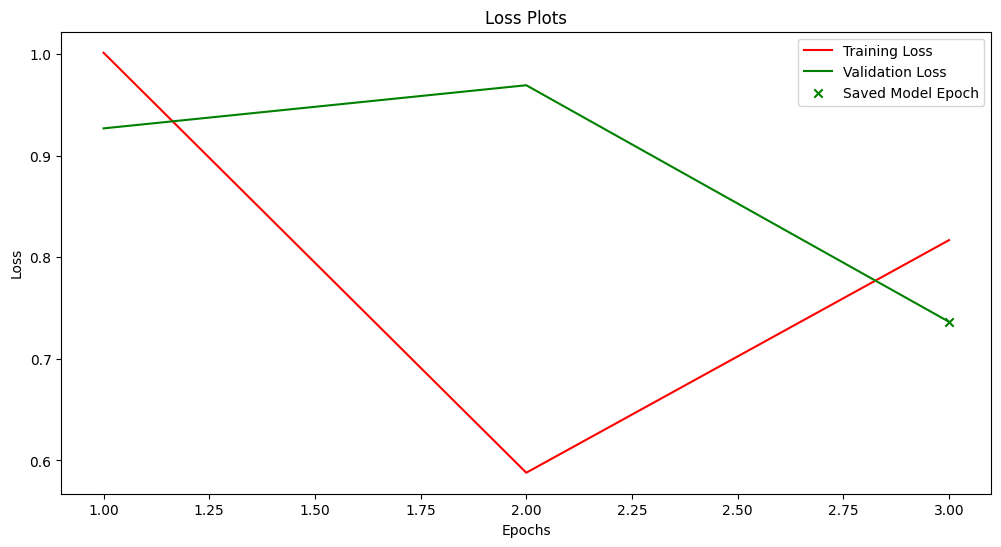

<Figure size 640x480 with 0 Axes>

In [221]:
device = torch.device(DEVICE)

model = get_model_instance_segmentation(num_classes)
model.to(device)

# TODO check (sample code)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
# TODO check (sample code)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

train_losses, val_losses, best_epoch = train(model, 
                                             optimizer, lr_scheduler, 
                                             train_loader, val_loader, lvis_gt_val, cat_ids,
                                             EPOCHS, PATIENCE, device, PRINT_FREQ)
plot_losses(train_losses, val_losses, early_stop = best_epoch, filepath="losses.jpg")


In [79]:
evaluate(model, train_loader, lvis_gt_train, cat_ids, device, iou_type="segm")

BATCHES:   0%|          | 0/7 [00:00<?, ?it/s]

[11/24 18:40:09] lvis.results WARNING: Assuming user provided the results in correct format.


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     s | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     m | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=     l | maxDets=300 catIds=all] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  r] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  c] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=  f] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 catIds=all] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=     s | maxDets=300 catIds=all] = 0.000
 Average

# --- tests ---

In [ ]:
images, targets = next(iter(train_loader))
show_image_list(images[:5])

In [211]:
from lvis import LVIS, LVISVis

predictions = get_predictions(model, val_loader, device)
if len(predictions) == 0:
    print("No detections — skipping LVIS evaluation.")
else:
    lvis_dt = LVISResults(lvis_gt_val, predictions)

lvis_vis = LVISVis(lvis_gt_val, lvis_dt, img_dir=COCO2017_VAL_PATH)

BATCHES:   0%|          | 0/2 [00:00<?, ?it/s]

[11/24 20:21:28] lvis.results WARNING: Assuming user provided the results in correct format.


400
222317
5633.72870317474
{'size': [480, 640], 'counts': 'Whf4120j>0VA1O0g>OZA1O0g>OZA1O0d=O]B0:030C1O000d=O]B000010O00037MI1O000d=O]B001O00016OJ1O0001O000d=O]B00001O01O037MI1O000d=O]B00040L0`00@1O0d=OgB0F0`00@1O0Q>OPB0`00@1O0Q>OPB0`00@1O0d=OgB0F0`00@1O0d=O]B00040L3=1BMd=O]B00001O013OL;4EMd=O]B001O00:0E50L4OMd=O]B00001O013OL;4EMd=O]B000010O03?O@Od=OgB0F0c01\\O0d=OgB0F0c01\\O0Q>OPB0c01\\O0d=OgB0F0c01\\O0d=O]B00010N11O00`01_O0d=O]B00001O0001O00=4V=L]B001O0061I70L4`=L]B00001O0001O0070L4`=L]B00040L000`01_O0d=OgB0F0c01\\O0j>0VA0j>0VA0d=OgB0F0c01\\O0d=OfB1F01O`01_O0d=O]B001O0031L0070I004c=L]B001O61I00010O000004c=L]B001O61I00010O000004c=L]B00001O31L=0C1O0d=OfB1F01O`01_O0P>0QBOc00]O1P>OPB0c00]O1o=0QBOc00]O1c=OfB4GL`01_O0d=O]B000070I0070I001O0d=O]B001O61I00010O000001O0d=O]B001O61I00010O000001O0d=O]B000070I:0F001O0d=OcB1I01Of01V>0P?0g_OOcB1I01Of01m<O]B00:0F:0F00001c=O]B00:0F0040L00001O0d=O]B00:0F00010O000001O0d=O]B00:0F70I0000000d=0\\B001O0d>O]A001f>O]A0d>0\\A1c>OZA001O0d>O]A:0F00:0F000g=0YB:0

ValueError: not enough values to unpack (expected 2, got 1)

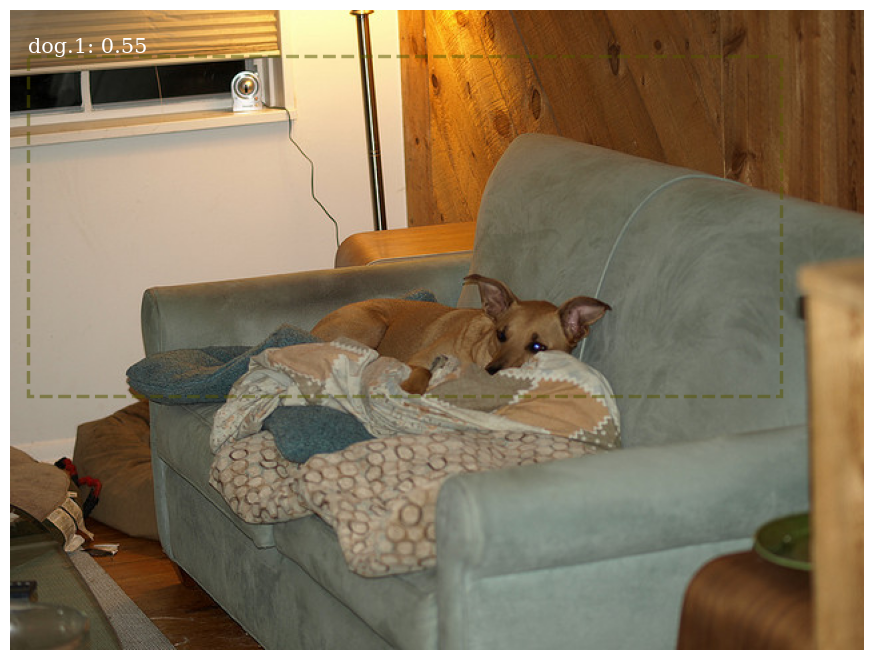

In [216]:
print(len(lvis_dt.anns))
i = 2
print(lvis_dt.anns[i]["image_id"])
print(lvis_dt.anns[i]["area"])
print(np.sum(lvis_dt.anns[i]["segmentation"]))

lvis_vis.vis_result(222317, show_boxes=True, show_classes=True)

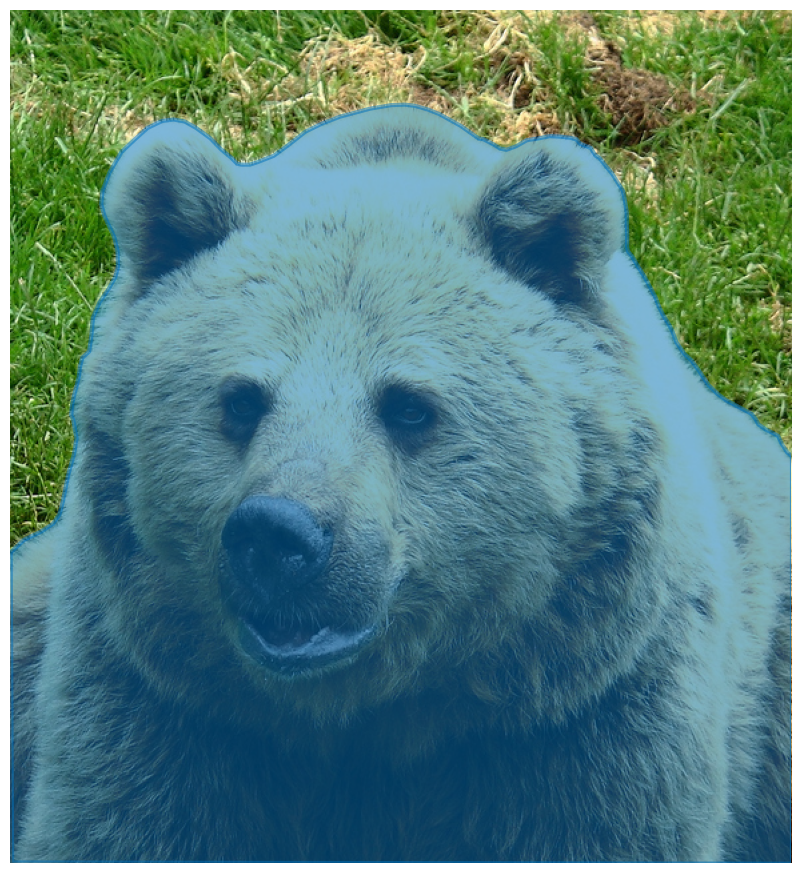

In [80]:
from lvis import LVIS, LVISVis

lvis_gt = LVIS(VAL_ANNOT_PATH)

lvis_vis = LVISVis(lvis_gt, img_dir=COCO2017_VAL_PATH)

lvis_vis.vis_img(285)

In [ ]:
# model training output
model = get_model_instance_segmentation(num_classes)
print("debug 1")
images, targets = next(iter(train_loader))
print("debug 2")
images = list(image for image in images)
print("debug 3")
targets = [{k: v for k, v in t.items()} for t in targets]
print("debug 4")
output = model(images, targets)  # Returns losses and detections
print("debug 5")
print(output)

In [ ]:
# model inference output
@torch.inference_mode()
def test(model) :
    model.eval()
    print("debug 1")
    x = [torch.rand(3, 300, 400).to(device), torch.rand(3, 500, 400).to(device)]
    print("debug 2")
    predictions = model(x)  # Returns predictions
    print("debug 3")
    print(predictions[0])

test(model)

In [ ]:
# evaluate test

from torch.utils.data import Subset

device = torch.device(DEVICE)
val_subset = Subset(dataset_val, indices=range(10))
val_subset_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)
model = get_model_instance_segmentation(num_classes)
model.to(device)
for images, targets in val_loader:
    print(type(targets), targets)
    break
    
print("collate_fn =", val_loader.collate_fn)



evaluate(model, val_loader, lvis_gt_val, device)

In [ ]:
import cv2

img = cv2.imread("../coco2017/train2017/000000055296.jpg")
if img is None : 
    print("erreur imgage pas found")
cv2.imshow("test", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import json

with open("data/lvis_v1_val.json", "r") as f:
    data = json.load(f)


category_fields = list(data["categories"][0].keys())

print(category_fields)
